# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [71]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

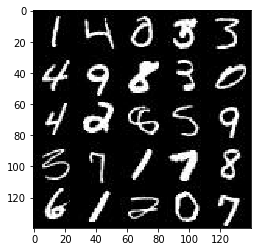

In [72]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

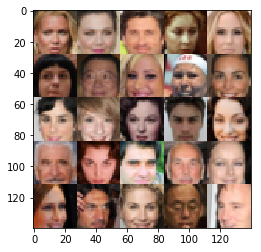

In [73]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [75]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [76]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        # conv1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=tf.nn.relu)
        
        # conv2
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=tf.nn.relu)
        
        # conv3
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=tf.nn.relu)
        
        # flatten
        flat = tf.reshape(x3, (-1, 4 * 4 * 256))
        
        # out
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [77]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # fc
        x1 = tf.layers.dense(z, 7 * 7 * 512)

        #  reshape
        x1 = tf.reshape(x1, (-1, 7, 7,512))
#         x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)

        # conv1
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
#         x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)

        # conv2
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)

        # out
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [78]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [79]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [80]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [81]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode)
    # 2 None None None None <bound method Dataset.get_batches...> (60000, 28, 28, 1) L
    
    steps = 0
    # def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real, inputs_z, inputs_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], 
                                                               z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, 
                                               inputs_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_learning_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={inputs_z: batch_z})
                    
                    print("Epoch {}/{}".format(epoch_i + 1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    # def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                    show_generator_output(sess, 10, inputs_z, data_shape[3], data_image_mode)
                    
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

2 128 100 0.002 0.5 <bound method Dataset.get_batches of <helper.Dataset object at 0x7fe763806710>> (60000, 28, 28, 1) L
Epoch 1/2 Discriminator Loss: 13.4111 Generator Loss: 1.8129
Epoch 1/2 Discriminator Loss: 5.0014 Generator Loss: 5.9011
Epoch 1/2 Discriminator Loss: 3.8021 Generator Loss: 0.2917
Epoch 1/2 Discriminator Loss: 0.4994 Generator Loss: 2.2946
Epoch 1/2 Discriminator Loss: 0.2280 Generator Loss: 1.9518
Epoch 1/2 Discriminator Loss: 4.0943 Generator Loss: 0.8480
Epoch 1/2 Discriminator Loss: 0.8202 Generator Loss: 3.2252
Epoch 1/2 Discriminator Loss: 0.5163 Generator Loss: 2.0658
Epoch 1/2 Discriminator Loss: 0.1253 Generator Loss: 2.7594
Epoch 1/2 Discriminator Loss: 0.4935 Generator Loss: 1.5894


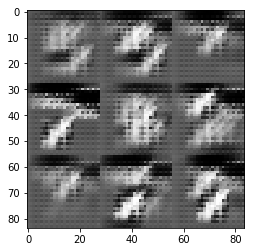

Epoch 1/2 Discriminator Loss: 0.7051 Generator Loss: 1.2115
Epoch 1/2 Discriminator Loss: 0.4601 Generator Loss: 3.8302
Epoch 1/2 Discriminator Loss: 0.7249 Generator Loss: 1.4248
Epoch 1/2 Discriminator Loss: 0.7474 Generator Loss: 1.3667
Epoch 1/2 Discriminator Loss: 0.7840 Generator Loss: 1.3360
Epoch 1/2 Discriminator Loss: 0.7143 Generator Loss: 2.0228
Epoch 1/2 Discriminator Loss: 0.2636 Generator Loss: 2.2195
Epoch 1/2 Discriminator Loss: 0.9244 Generator Loss: 1.2034
Epoch 1/2 Discriminator Loss: 2.8787 Generator Loss: 0.1326
Epoch 1/2 Discriminator Loss: 0.5754 Generator Loss: 1.8094


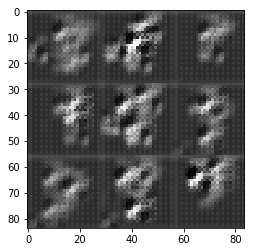

Epoch 1/2 Discriminator Loss: 0.4497 Generator Loss: 1.8944
Epoch 1/2 Discriminator Loss: 0.6185 Generator Loss: 1.3927
Epoch 1/2 Discriminator Loss: 0.8276 Generator Loss: 3.0613
Epoch 1/2 Discriminator Loss: 0.7661 Generator Loss: 1.3136
Epoch 1/2 Discriminator Loss: 0.5052 Generator Loss: 1.4933
Epoch 1/2 Discriminator Loss: 0.6177 Generator Loss: 1.1720
Epoch 1/2 Discriminator Loss: 0.7673 Generator Loss: 1.1172
Epoch 1/2 Discriminator Loss: 0.5445 Generator Loss: 1.4788
Epoch 1/2 Discriminator Loss: 2.9998 Generator Loss: 0.0860
Epoch 1/2 Discriminator Loss: 0.6372 Generator Loss: 1.4056


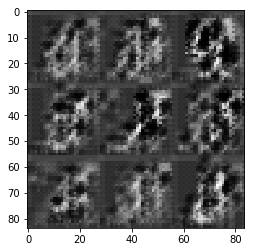

Epoch 1/2 Discriminator Loss: 1.0368 Generator Loss: 0.6771
Epoch 1/2 Discriminator Loss: 0.6693 Generator Loss: 1.3624
Epoch 1/2 Discriminator Loss: 0.3054 Generator Loss: 2.2725
Epoch 1/2 Discriminator Loss: 0.8485 Generator Loss: 0.9426
Epoch 1/2 Discriminator Loss: 0.5530 Generator Loss: 1.2356
Epoch 1/2 Discriminator Loss: 0.3265 Generator Loss: 2.3079
Epoch 1/2 Discriminator Loss: 0.4805 Generator Loss: 2.1650
Epoch 1/2 Discriminator Loss: 0.4735 Generator Loss: 2.2854
Epoch 1/2 Discriminator Loss: 0.5331 Generator Loss: 1.2886
Epoch 1/2 Discriminator Loss: 0.5420 Generator Loss: 1.7035


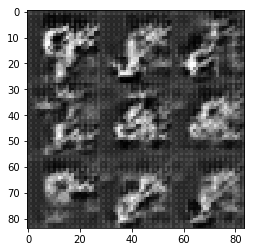

Epoch 1/2 Discriminator Loss: 1.4308 Generator Loss: 0.4364
Epoch 1/2 Discriminator Loss: 0.5111 Generator Loss: 2.1024
Epoch 1/2 Discriminator Loss: 0.6296 Generator Loss: 1.4384
Epoch 1/2 Discriminator Loss: 0.6375 Generator Loss: 1.3117
Epoch 1/2 Discriminator Loss: 0.6026 Generator Loss: 1.4230
Epoch 1/2 Discriminator Loss: 0.6024 Generator Loss: 2.0345
Epoch 2/2 Discriminator Loss: 0.3959 Generator Loss: 2.1256
Epoch 2/2 Discriminator Loss: 0.4159 Generator Loss: 1.7452
Epoch 2/2 Discriminator Loss: 2.8438 Generator Loss: 0.1557
Epoch 2/2 Discriminator Loss: 0.4489 Generator Loss: 1.7393


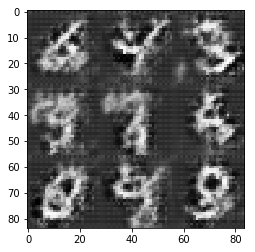

Epoch 2/2 Discriminator Loss: 0.4236 Generator Loss: 2.0906
Epoch 2/2 Discriminator Loss: 0.4176 Generator Loss: 1.9215
Epoch 2/2 Discriminator Loss: 0.3075 Generator Loss: 2.0929
Epoch 2/2 Discriminator Loss: 0.4545 Generator Loss: 1.8264
Epoch 2/2 Discriminator Loss: 0.4343 Generator Loss: 2.3286
Epoch 2/2 Discriminator Loss: 0.9124 Generator Loss: 0.9208
Epoch 2/2 Discriminator Loss: 0.6066 Generator Loss: 1.3764
Epoch 2/2 Discriminator Loss: 0.3700 Generator Loss: 1.9237
Epoch 2/2 Discriminator Loss: 0.2094 Generator Loss: 4.0447
Epoch 2/2 Discriminator Loss: 0.3558 Generator Loss: 2.2648


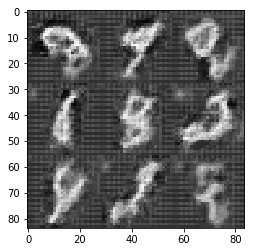

Epoch 2/2 Discriminator Loss: 0.3974 Generator Loss: 2.5584
Epoch 2/2 Discriminator Loss: 0.3855 Generator Loss: 2.1448
Epoch 2/2 Discriminator Loss: 0.2252 Generator Loss: 4.3182
Epoch 2/2 Discriminator Loss: 0.1387 Generator Loss: 4.7562
Epoch 2/2 Discriminator Loss: 0.4374 Generator Loss: 2.6175
Epoch 2/2 Discriminator Loss: 0.2405 Generator Loss: 2.7569
Epoch 2/2 Discriminator Loss: 0.3891 Generator Loss: 1.9093
Epoch 2/2 Discriminator Loss: 0.3103 Generator Loss: 2.3323
Epoch 2/2 Discriminator Loss: 0.2065 Generator Loss: 3.2928
Epoch 2/2 Discriminator Loss: 0.4579 Generator Loss: 1.9498


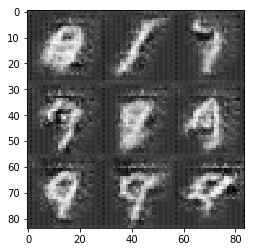

Epoch 2/2 Discriminator Loss: 0.4118 Generator Loss: 2.8987
Epoch 2/2 Discriminator Loss: 0.3574 Generator Loss: 2.3009
Epoch 2/2 Discriminator Loss: 0.1830 Generator Loss: 3.0030
Epoch 2/2 Discriminator Loss: 0.3612 Generator Loss: 2.5110
Epoch 2/2 Discriminator Loss: 0.3224 Generator Loss: 2.6885
Epoch 2/2 Discriminator Loss: 0.3810 Generator Loss: 2.3879
Epoch 2/2 Discriminator Loss: 0.4704 Generator Loss: 2.2311
Epoch 2/2 Discriminator Loss: 0.4319 Generator Loss: 1.8998
Epoch 2/2 Discriminator Loss: 0.1227 Generator Loss: 4.1125
Epoch 2/2 Discriminator Loss: 0.2572 Generator Loss: 2.5065


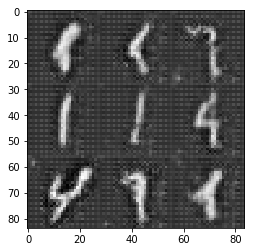

Epoch 2/2 Discriminator Loss: 0.2280 Generator Loss: 2.6624
Epoch 2/2 Discriminator Loss: 0.1444 Generator Loss: 4.6039
Epoch 2/2 Discriminator Loss: 0.2445 Generator Loss: 4.8844
Epoch 2/2 Discriminator Loss: 0.1446 Generator Loss: 4.2131
Epoch 2/2 Discriminator Loss: 3.1370 Generator Loss: 0.2490
Epoch 2/2 Discriminator Loss: 0.4375 Generator Loss: 1.7517
Epoch 2/2 Discriminator Loss: 0.3774 Generator Loss: 2.1250
Epoch 2/2 Discriminator Loss: 0.6498 Generator Loss: 3.7499
Epoch 2/2 Discriminator Loss: 0.5638 Generator Loss: 3.3209
Epoch 2/2 Discriminator Loss: 0.3966 Generator Loss: 2.1751


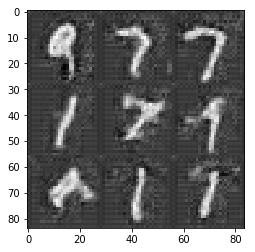

Epoch 2/2 Discriminator Loss: 0.2897 Generator Loss: 2.6576
Epoch 2/2 Discriminator Loss: 0.4837 Generator Loss: 1.7557
Epoch 2/2 Discriminator Loss: 0.5312 Generator Loss: 1.7173


In [82]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

1 128 100 0.0003 0.5 <bound method Dataset.get_batches of <helper.Dataset object at 0x7fe763342b00>> (202599, 28, 28, 3) RGB
Epoch 1/1 Discriminator Loss: 0.8718 Generator Loss: 0.7058
Epoch 1/1 Discriminator Loss: 0.8941 Generator Loss: 0.6860
Epoch 1/1 Discriminator Loss: 0.8841 Generator Loss: 0.9128
Epoch 1/1 Discriminator Loss: 0.9448 Generator Loss: 0.7233
Epoch 1/1 Discriminator Loss: 1.2840 Generator Loss: 0.6244
Epoch 1/1 Discriminator Loss: 0.8306 Generator Loss: 1.1124
Epoch 1/1 Discriminator Loss: 0.9594 Generator Loss: 0.7710
Epoch 1/1 Discriminator Loss: 1.6392 Generator Loss: 0.5962
Epoch 1/1 Discriminator Loss: 1.2700 Generator Loss: 0.7771
Epoch 1/1 Discriminator Loss: 1.2445 Generator Loss: 0.7405


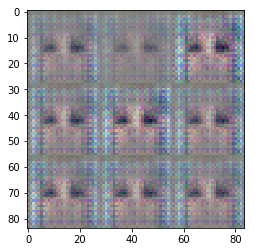

Epoch 1/1 Discriminator Loss: 1.4322 Generator Loss: 0.5392
Epoch 1/1 Discriminator Loss: 1.4103 Generator Loss: 0.7874
Epoch 1/1 Discriminator Loss: 1.3166 Generator Loss: 0.8113
Epoch 1/1 Discriminator Loss: 1.2895 Generator Loss: 0.8293
Epoch 1/1 Discriminator Loss: 1.6135 Generator Loss: 0.4732
Epoch 1/1 Discriminator Loss: 1.3398 Generator Loss: 1.0063
Epoch 1/1 Discriminator Loss: 1.1158 Generator Loss: 0.9398
Epoch 1/1 Discriminator Loss: 1.1891 Generator Loss: 0.7874
Epoch 1/1 Discriminator Loss: 1.8307 Generator Loss: 0.3399
Epoch 1/1 Discriminator Loss: 1.1918 Generator Loss: 0.7400


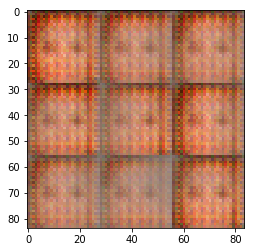

Epoch 1/1 Discriminator Loss: 1.5393 Generator Loss: 0.4818
Epoch 1/1 Discriminator Loss: 1.2811 Generator Loss: 0.8951
Epoch 1/1 Discriminator Loss: 0.9278 Generator Loss: 0.8001
Epoch 1/1 Discriminator Loss: 1.1679 Generator Loss: 0.6642
Epoch 1/1 Discriminator Loss: 1.2072 Generator Loss: 0.6804
Epoch 1/1 Discriminator Loss: 1.3543 Generator Loss: 0.6228
Epoch 1/1 Discriminator Loss: 1.6040 Generator Loss: 0.7000
Epoch 1/1 Discriminator Loss: 1.4452 Generator Loss: 0.7427
Epoch 1/1 Discriminator Loss: 1.2552 Generator Loss: 0.8496
Epoch 1/1 Discriminator Loss: 1.2712 Generator Loss: 0.8940


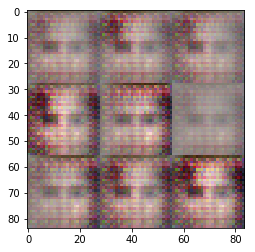

Epoch 1/1 Discriminator Loss: 1.0746 Generator Loss: 0.9249
Epoch 1/1 Discriminator Loss: 1.0136 Generator Loss: 0.9468
Epoch 1/1 Discriminator Loss: 0.9912 Generator Loss: 1.1065
Epoch 1/1 Discriminator Loss: 1.2405 Generator Loss: 0.9411
Epoch 1/1 Discriminator Loss: 0.7143 Generator Loss: 1.0417
Epoch 1/1 Discriminator Loss: 1.6437 Generator Loss: 1.7057
Epoch 1/1 Discriminator Loss: 1.0250 Generator Loss: 1.1238
Epoch 1/1 Discriminator Loss: 0.9657 Generator Loss: 1.0742
Epoch 1/1 Discriminator Loss: 2.3272 Generator Loss: 0.3637
Epoch 1/1 Discriminator Loss: 1.9048 Generator Loss: 0.3870


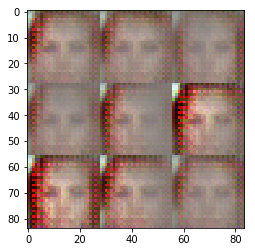

Epoch 1/1 Discriminator Loss: 1.0643 Generator Loss: 1.1595
Epoch 1/1 Discriminator Loss: 1.1433 Generator Loss: 0.8328
Epoch 1/1 Discriminator Loss: 1.5174 Generator Loss: 0.6771
Epoch 1/1 Discriminator Loss: 1.1266 Generator Loss: 0.9672
Epoch 1/1 Discriminator Loss: 0.9164 Generator Loss: 0.9246
Epoch 1/1 Discriminator Loss: 0.8209 Generator Loss: 1.2148
Epoch 1/1 Discriminator Loss: 1.2983 Generator Loss: 0.8192
Epoch 1/1 Discriminator Loss: 1.2961 Generator Loss: 0.7110
Epoch 1/1 Discriminator Loss: 1.2564 Generator Loss: 1.0343
Epoch 1/1 Discriminator Loss: 0.9903 Generator Loss: 0.9141


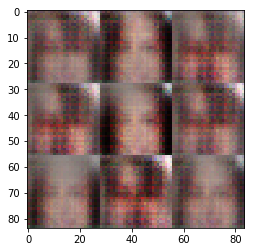

Epoch 1/1 Discriminator Loss: 1.3996 Generator Loss: 0.8021
Epoch 1/1 Discriminator Loss: 1.0214 Generator Loss: 1.0893
Epoch 1/1 Discriminator Loss: 1.0404 Generator Loss: 0.8818
Epoch 1/1 Discriminator Loss: 1.6185 Generator Loss: 0.6678
Epoch 1/1 Discriminator Loss: 1.1809 Generator Loss: 0.8707
Epoch 1/1 Discriminator Loss: 1.5031 Generator Loss: 0.6736
Epoch 1/1 Discriminator Loss: 1.3228 Generator Loss: 0.7360
Epoch 1/1 Discriminator Loss: 1.2343 Generator Loss: 0.8633
Epoch 1/1 Discriminator Loss: 1.2906 Generator Loss: 0.6841
Epoch 1/1 Discriminator Loss: 1.0017 Generator Loss: 0.9964


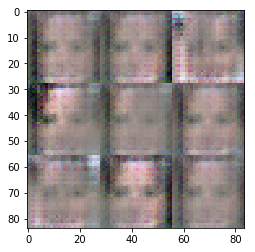

Epoch 1/1 Discriminator Loss: 1.2325 Generator Loss: 0.8634
Epoch 1/1 Discriminator Loss: 0.9618 Generator Loss: 1.2535
Epoch 1/1 Discriminator Loss: 1.0067 Generator Loss: 1.2592
Epoch 1/1 Discriminator Loss: 0.8652 Generator Loss: 1.2276
Epoch 1/1 Discriminator Loss: 1.1853 Generator Loss: 1.1068
Epoch 1/1 Discriminator Loss: 1.3558 Generator Loss: 0.6805
Epoch 1/1 Discriminator Loss: 1.6037 Generator Loss: 0.5804
Epoch 1/1 Discriminator Loss: 1.4462 Generator Loss: 0.7219
Epoch 1/1 Discriminator Loss: 1.0840 Generator Loss: 1.0295
Epoch 1/1 Discriminator Loss: 1.4189 Generator Loss: 0.6159


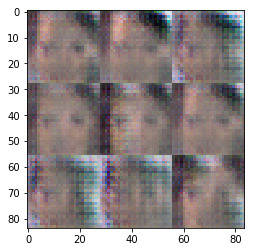

Epoch 1/1 Discriminator Loss: 1.0763 Generator Loss: 1.1257
Epoch 1/1 Discriminator Loss: 1.3581 Generator Loss: 0.8121
Epoch 1/1 Discriminator Loss: 1.4137 Generator Loss: 0.6699
Epoch 1/1 Discriminator Loss: 1.2552 Generator Loss: 0.6280
Epoch 1/1 Discriminator Loss: 2.1887 Generator Loss: 0.4349
Epoch 1/1 Discriminator Loss: 1.1715 Generator Loss: 0.8522
Epoch 1/1 Discriminator Loss: 1.4693 Generator Loss: 0.6055
Epoch 1/1 Discriminator Loss: 1.1753 Generator Loss: 0.7789
Epoch 1/1 Discriminator Loss: 1.2162 Generator Loss: 0.8782
Epoch 1/1 Discriminator Loss: 1.8063 Generator Loss: 0.9086


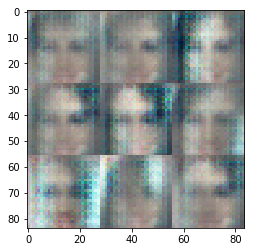

Epoch 1/1 Discriminator Loss: 1.2973 Generator Loss: 0.7454
Epoch 1/1 Discriminator Loss: 1.2240 Generator Loss: 0.7049
Epoch 1/1 Discriminator Loss: 1.1309 Generator Loss: 0.8148
Epoch 1/1 Discriminator Loss: 1.2659 Generator Loss: 0.8311
Epoch 1/1 Discriminator Loss: 1.0156 Generator Loss: 1.0515
Epoch 1/1 Discriminator Loss: 1.3796 Generator Loss: 0.8134
Epoch 1/1 Discriminator Loss: 1.3739 Generator Loss: 0.7849
Epoch 1/1 Discriminator Loss: 1.2644 Generator Loss: 0.8828
Epoch 1/1 Discriminator Loss: 1.4604 Generator Loss: 0.6173
Epoch 1/1 Discriminator Loss: 1.3256 Generator Loss: 0.7259


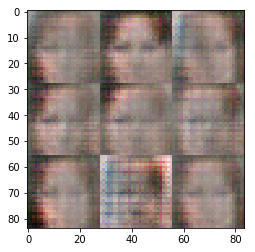

Epoch 1/1 Discriminator Loss: 1.2300 Generator Loss: 0.9266
Epoch 1/1 Discriminator Loss: 1.0947 Generator Loss: 0.8456
Epoch 1/1 Discriminator Loss: 1.1966 Generator Loss: 0.9849
Epoch 1/1 Discriminator Loss: 1.0796 Generator Loss: 0.9849
Epoch 1/1 Discriminator Loss: 1.3115 Generator Loss: 0.8308
Epoch 1/1 Discriminator Loss: 1.3680 Generator Loss: 0.7886
Epoch 1/1 Discriminator Loss: 1.2420 Generator Loss: 0.9176
Epoch 1/1 Discriminator Loss: 1.2491 Generator Loss: 0.7804
Epoch 1/1 Discriminator Loss: 1.2040 Generator Loss: 0.7957
Epoch 1/1 Discriminator Loss: 1.3466 Generator Loss: 0.7084


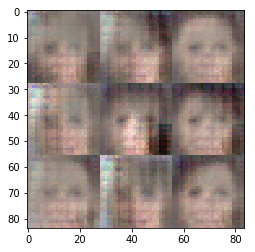

Epoch 1/1 Discriminator Loss: 1.4758 Generator Loss: 0.6900
Epoch 1/1 Discriminator Loss: 1.2697 Generator Loss: 0.8076
Epoch 1/1 Discriminator Loss: 1.2012 Generator Loss: 0.8511
Epoch 1/1 Discriminator Loss: 1.3098 Generator Loss: 0.9721
Epoch 1/1 Discriminator Loss: 1.2605 Generator Loss: 0.7298
Epoch 1/1 Discriminator Loss: 1.1933 Generator Loss: 0.8913
Epoch 1/1 Discriminator Loss: 1.4304 Generator Loss: 0.8300
Epoch 1/1 Discriminator Loss: 1.3345 Generator Loss: 0.7887
Epoch 1/1 Discriminator Loss: 1.2895 Generator Loss: 0.6787
Epoch 1/1 Discriminator Loss: 1.4176 Generator Loss: 0.6867


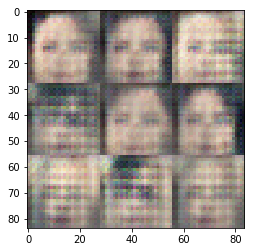

Epoch 1/1 Discriminator Loss: 1.4038 Generator Loss: 0.7072
Epoch 1/1 Discriminator Loss: 1.1524 Generator Loss: 0.7207
Epoch 1/1 Discriminator Loss: 1.2311 Generator Loss: 0.7473
Epoch 1/1 Discriminator Loss: 1.6166 Generator Loss: 0.8780
Epoch 1/1 Discriminator Loss: 1.2246 Generator Loss: 0.7211
Epoch 1/1 Discriminator Loss: 1.3378 Generator Loss: 0.8844
Epoch 1/1 Discriminator Loss: 1.3478 Generator Loss: 0.6814
Epoch 1/1 Discriminator Loss: 1.3339 Generator Loss: 0.8475
Epoch 1/1 Discriminator Loss: 1.3456 Generator Loss: 0.8083
Epoch 1/1 Discriminator Loss: 1.2094 Generator Loss: 0.7053


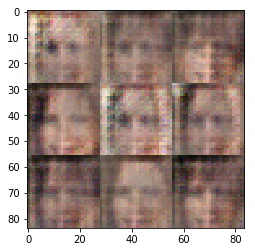

Epoch 1/1 Discriminator Loss: 1.5973 Generator Loss: 0.7111
Epoch 1/1 Discriminator Loss: 1.4265 Generator Loss: 0.6631
Epoch 1/1 Discriminator Loss: 1.3598 Generator Loss: 0.6388
Epoch 1/1 Discriminator Loss: 1.3343 Generator Loss: 0.8260
Epoch 1/1 Discriminator Loss: 1.3202 Generator Loss: 0.7710
Epoch 1/1 Discriminator Loss: 1.3122 Generator Loss: 0.6905
Epoch 1/1 Discriminator Loss: 1.3790 Generator Loss: 0.8187
Epoch 1/1 Discriminator Loss: 1.3163 Generator Loss: 0.7357
Epoch 1/1 Discriminator Loss: 1.2865 Generator Loss: 0.8097
Epoch 1/1 Discriminator Loss: 1.3868 Generator Loss: 0.6495


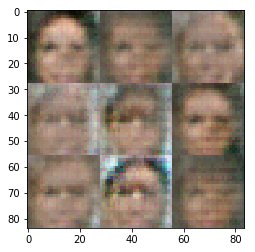

Epoch 1/1 Discriminator Loss: 1.3790 Generator Loss: 0.7611
Epoch 1/1 Discriminator Loss: 1.3378 Generator Loss: 0.7537
Epoch 1/1 Discriminator Loss: 1.2516 Generator Loss: 0.7712
Epoch 1/1 Discriminator Loss: 1.4281 Generator Loss: 0.6835
Epoch 1/1 Discriminator Loss: 1.4106 Generator Loss: 0.7237
Epoch 1/1 Discriminator Loss: 1.2930 Generator Loss: 0.7519
Epoch 1/1 Discriminator Loss: 1.3365 Generator Loss: 0.6808
Epoch 1/1 Discriminator Loss: 1.3411 Generator Loss: 0.7911
Epoch 1/1 Discriminator Loss: 1.2866 Generator Loss: 0.6638
Epoch 1/1 Discriminator Loss: 1.4282 Generator Loss: 0.7430


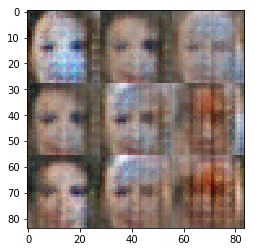

Epoch 1/1 Discriminator Loss: 1.3359 Generator Loss: 0.7679
Epoch 1/1 Discriminator Loss: 1.4830 Generator Loss: 0.6552
Epoch 1/1 Discriminator Loss: 1.2570 Generator Loss: 0.6809
Epoch 1/1 Discriminator Loss: 1.3622 Generator Loss: 0.8140
Epoch 1/1 Discriminator Loss: 1.3121 Generator Loss: 0.7294
Epoch 1/1 Discriminator Loss: 1.3842 Generator Loss: 0.7874
Epoch 1/1 Discriminator Loss: 1.4282 Generator Loss: 0.6204
Epoch 1/1 Discriminator Loss: 1.3029 Generator Loss: 0.7525
Epoch 1/1 Discriminator Loss: 1.3442 Generator Loss: 0.6914
Epoch 1/1 Discriminator Loss: 1.3019 Generator Loss: 0.8150


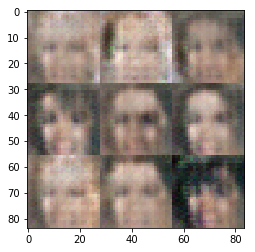

Epoch 1/1 Discriminator Loss: 1.3182 Generator Loss: 0.6822
Epoch 1/1 Discriminator Loss: 1.3067 Generator Loss: 0.8319
Epoch 1/1 Discriminator Loss: 1.2806 Generator Loss: 0.6690
Epoch 1/1 Discriminator Loss: 1.3373 Generator Loss: 0.8437
Epoch 1/1 Discriminator Loss: 1.3779 Generator Loss: 0.7084
Epoch 1/1 Discriminator Loss: 1.2828 Generator Loss: 0.7242
Epoch 1/1 Discriminator Loss: 1.4115 Generator Loss: 0.6687
Epoch 1/1 Discriminator Loss: 1.3127 Generator Loss: 0.7224


In [87]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.